1. Найти и подготовить данные для задачи классификации или
регрессии:
• Найдите набор данных для решения задачи классификации
или регрессии. Данные не должны повторяться между участниками
группы.
• Подготовьте данные для анализа: проверьте их на наличие
пропусков, выбросов и при необходимости произведите очистку данных.


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = fetch_california_housing(as_frame=True)
df = data.frame
df.drop('Latitude', axis=1, inplace=True)
df.drop('Longitude', axis=1, inplace=True)
print(df.head())
print("Пропущенные значения:\n", df.isnull().sum())
df.dropna(inplace=True)

df=df.head(1000)

# Делим целевую переменную (цены на жилье) на классы (дешевое/дорогое жилье)
df['price_class'] = pd.qcut(df['MedHouseVal'], q=2, labels=[0, 1])

# Убираем старый целевой признак
df.drop('MedHouseVal', axis=1, inplace=True)
X = df.drop('price_class', axis=1)
y = df['price_class']

2. Построить дерево решений:
• Реализуйте дерево решений для задачи классификации или
регрессии с использованием библиотеки scikit-learn.
• Проведите обучение модели на ваших данных.

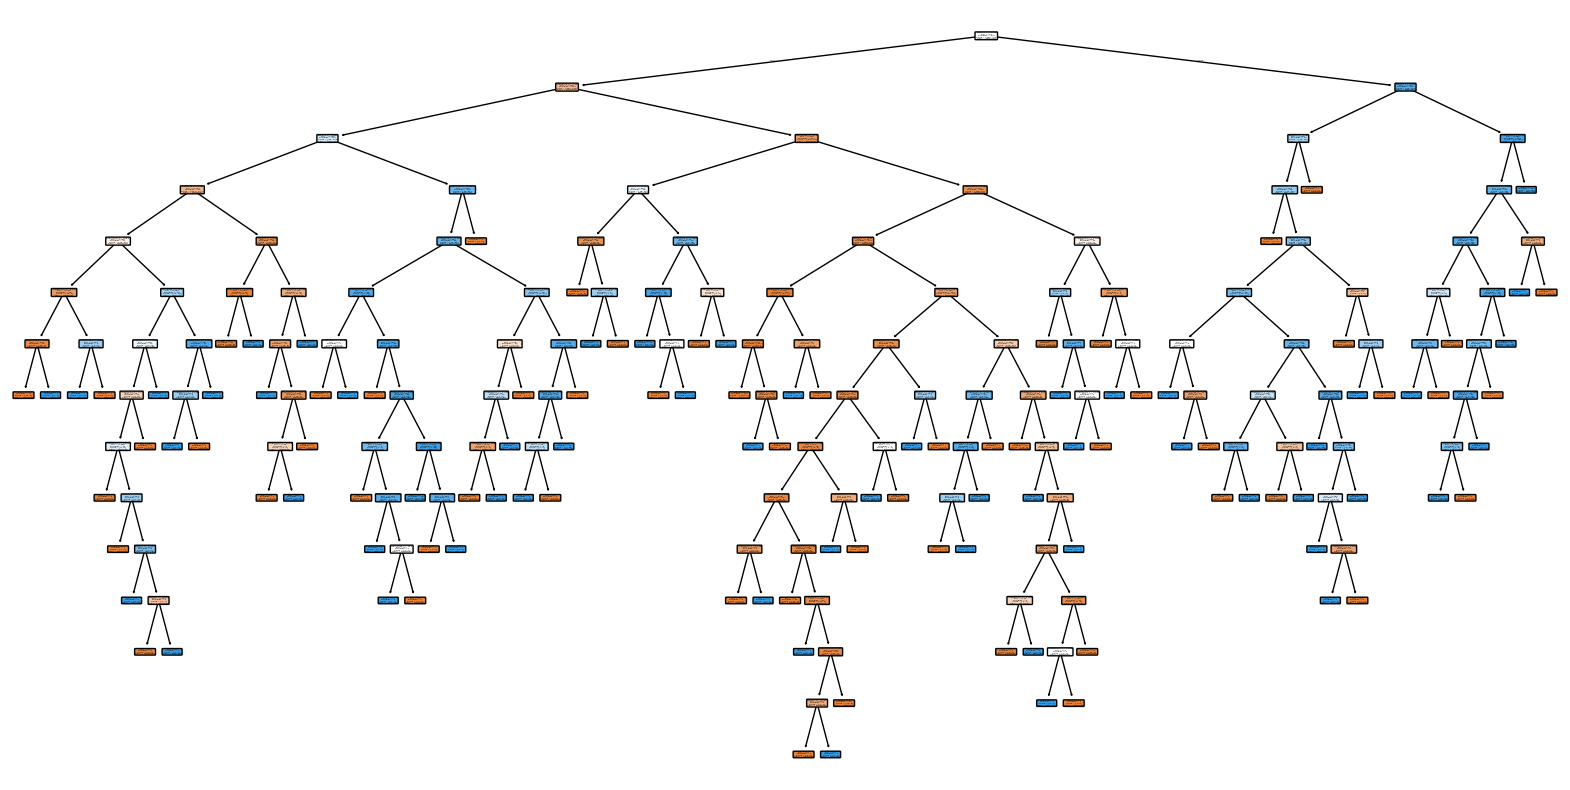

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#!pip install graphviz

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели дерева решений
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = clf.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Визуализация дерева решений
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Дешевое", "Дорогое"], rounded=True)
plt.show()

3. Подобрать гиперпараметры дерева решений:
• С помощью GridSearchCV выполните подбор оптимальных
гиперпараметров для дерева решений (например, глубина дерева,
минимальное количество образцов для разделения узла и т.д.).
• Оцените качество полученной модели с подобранными
параметрами с использованием метрик, таких как точность, F1-score,
RMSE или R^2 (в зависимости от задачи).

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Определяем параметры для поиска
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Инициализация модели дерева решений
clf = DecisionTreeClassifier(random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1)

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Оптимальные параметры
print("Лучшие параметры:", grid_search.best_params_)

# Оценка качества на тестовой выборке
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Метрики
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Точность модели: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nОтчет по классификации:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Точность модели: 0.8100
F1-Score: 0.7957

Отчет по классификации:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82       105
           1       0.81      0.78      0.80        95

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



4. Реализовать ансамбли моделей:
• Реализуйте следующие ансамбли моделей:
• Бэггинг (bagging)
• Бустинг (например, с помощью XGBoost, CatBoost или
LightGBM)
• Стекинг (stacking)
• Обучите ансамбли на тех же данных и сравните их с
результатами дерева решений.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score

# Бэггинг с деревом решений в качестве базовой модели
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging_clf.fit(X_train, y_train)

# Предсказания и оценка
y_pred_bagging = bagging_clf.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)

!pip install xgboost
import xgboost as xgb

# XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Предсказания и оценка
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Определение базовых моделей
estimators = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Стекинг с логистической регрессией в качестве мета-модели
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_clf.fit(X_train, y_train)

# Предсказания и оценка
y_pred_stacking = stacking_clf.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

print(f"Дерево решений - Точность: {accuracy:.4f}, F1-Score: {f1:.4f}")
print(f"Бэггинг - Точность: {accuracy_bagging:.4f}, F1-Score: {f1_bagging:.4f}")
print(f"XGBoost - Точность: {accuracy_xgb:.4f}, F1-Score: {f1_xgb:.4f}")
print(f"Стекинг - Точность: {accuracy_stacking:.4f}, F1-Score: {f1_stacking:.4f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Дерево решений - Точность: 0.8100, F1-Score: 0.7957
Бэггинг - Точность: 0.8050, F1-Score: 0.7892
XGBoost - Точность: 0.8350, F1-Score: 0.8197
Стекинг - Точность: 0.8250, F1-Score: 0.8087


5. Оценить качество моделей:
• Оцените качество ансамблей моделей с использованием
метрик, аналогичных тем, что использовались для дерева решений.
• Сравните производительность различных ансамблей с
базовой моделью дерева решений и сделайте выводы, какая модель
лучше решает задачу.

Наилучшим образом себя показал XGBoosting, тк точность и F1-Score наивысшая. Это связано с тем, что алгоритм исправляет ошибки предыдущих деревьев на основе ошибки их предсказаний. На 2 месте Стэкинг, он комбинирует несколько разных моделей, может показывать улучшенные результаты за счет использования сильных сторон каждой модели. На 3 месте дерево решений, эта модель является базовой, у нее простая реализация, но и соотвественно не лучшая точность. На 4 месте бэггинг, в большинстве случаев эта модель должна улучшить стабильность и уменьшить разброс (variance) по сравнению с одним деревом решений, но в нашем случае она показала себя хуже всех